# Sentiment Analysis + Machine Learning

# Imports

In [1]:
# pip install --upgrade tensorflow

In [2]:
%%time

# Common Imports:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import re

import lxml
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import plotly.express as px

import pandas as pd
import numpy as np
np.random.seed(42) # set a random seed (numpy)
import matplotlib.pyplot as plt
import requests

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

CPU times: user 3.29 s, sys: 2.28 s, total: 5.57 s
Wall time: 1.6 s


In [3]:
submissions = pd.read_csv('/home/ubuntu/0Data/submissionswithsentiment.csv', lineterminator='\n', index_col='Unnamed: 0')

In [4]:
subselftextsent = pd.read_csv('/home/ubuntu/0Data/submissionsSELFtextsentiment.csv', lineterminator='\n', index_col='Unnamed: 0')
subcleantextsent = pd.read_csv('/home/ubuntu/0Data/submissionsCLEANtextsentiment.csv', lineterminator='\n', index_col='Unnamed: 0')

In [5]:
subselftextsent.head(2)

,timestamp,title,subreddit,author,num_comments,redditscore,selftext,selftextwordcount,selftextnegative,selftextneutral,selftextpositive,selftextcompound
0,2021-03-14,Vanguard's poor ESG track record,investing,Dazen91,15,1,I know there's a huge consensus for vanguard f...,129,0.069,0.771,0.160,0.8965
1,2021-03-14,Daily Advice Thread - All basic help or advice...,investing,AutoModerator,160,1,"If your question is ""I have $10,000, what do I...",191,0.023,0.889,0.088,0.9053


In [6]:
subselftextsent.dtypes

timestamp             object
title                 object
subreddit             object
author                object
num_comments           int64
redditscore            int64
selftext              object
selftextwordcount      int64
selftextnegative     float64
selftextneutral      float64
selftextpositive     float64
selftextcompound     float64
dtype: object

(165672, 12)
(2995, 7)
(430, 7)
(100, 7)


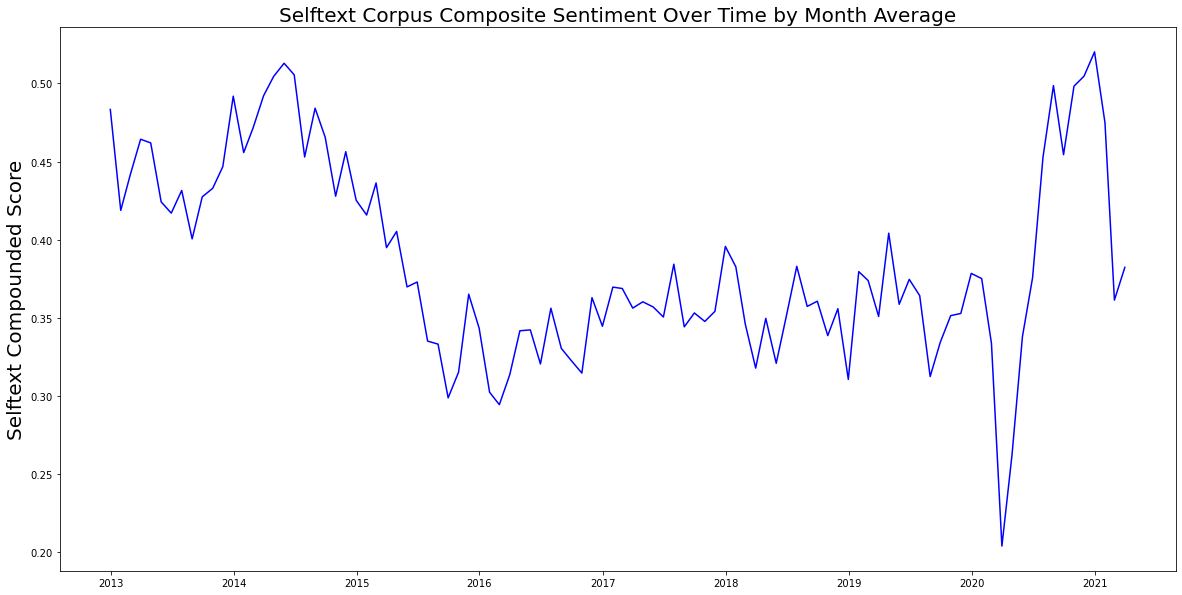

In [7]:
print(subselftextsent.shape)
subselftextsent['timestamp'] = pd.to_datetime(subselftextsent['timestamp'])

subselftextsentbyday = subselftextsent.groupby([subselftextsent['timestamp'].dt.date]).mean()
print(subselftextsentbyday.shape)

subselftextsentbyweek = subselftextsent.set_index('timestamp').resample('W').mean()
#subselftextsentbyweek.dropna(inplace=True)
print(subselftextsentbyweek.shape)

subselftextsentbymonth = subselftextsent.set_index('timestamp').resample('M').mean()
#subselftextsentbymonth.dropna(inplace=True)
print(subselftextsentbymonth.shape)

# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(subselftextsentbymonth.index, subselftextsentbymonth.selftextcompound, color = "blue")
# Create a descriptive title
plt.title("Selftext Corpus Composite Sentiment Over Time by Month Average",size=20)
#plt.legend(['Cleantext'])

# Add axis labels
plt.ylabel("Selftext Compounded Score",size=20);

tslaselftextshape (4210, 12)
tslatitleshape (2126, 12)
tsladatashape(combined) (6336, 12)
tsladatashapebyday (1915, 7)
tsladatashapebyweek (421, 7)
tsladatashapebymonth (99, 7)


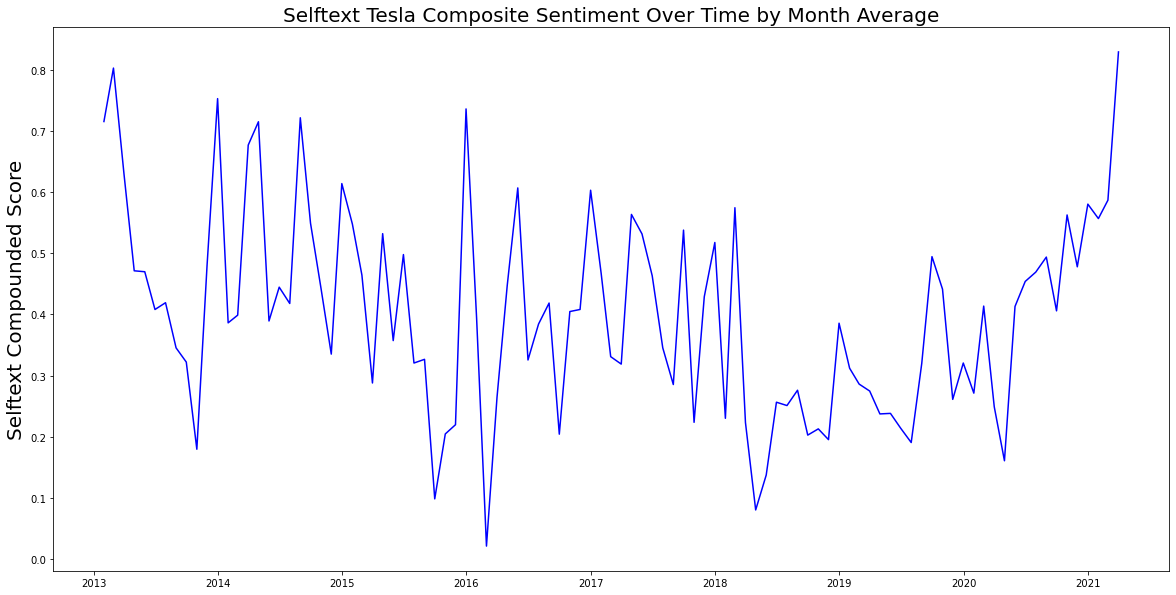

In [8]:
tslaselftext = subselftextsent[subselftextsent['selftext'].str.contains('Tesla|TSLA|tsla|Tsla|Elon|Musk|elon')]
print("tslaselftextshape", tslaselftext.shape)

tslatitle = subselftextsent[subselftextsent['title'].str.contains('Tesla|TSLA|tsla|Tsla')]
print("tslatitleshape",tslatitle.shape)

tsladata = pd.concat([tslaselftext, tslatitle], axis=0)
tsladata['timestamp'] = pd.to_datetime(tsladata['timestamp'])
print("tsladatashape(combined)",tsladata.shape)

tsladatabyday = tsladata.groupby([tsladata['timestamp'].dt.date]).mean()
print("tsladatashapebyday",tsladatabyday.shape)

tsladatabyweek = tsladata.set_index('timestamp').resample('W').mean()
tsladatabyweek.dropna(inplace=True)
print("tsladatashapebyweek", tsladatabyweek.shape)

tsladatabymonth = tsladata.set_index('timestamp').resample('M').mean()
tsladatabymonth.dropna(inplace=True)
print("tsladatashapebymonth", tsladatabymonth.shape)

# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(tsladatabymonth.index, tsladatabymonth.selftextcompound, color = "blue")
# Create a descriptive title
plt.title("Selftext Tesla Composite Sentiment Over Time by Month Average",size=20)
#plt.legend(['Cleantext'])

# Add axis labels
plt.ylabel("Selftext Compounded Score",size=20);

gmeselftextshape (1756, 12)
gmetitleshape (548, 12)
gmedatashape(combined) (2304, 12)
gmedatashapebyday (968, 7)
gmedatashapebyweek (428, 7)
gmedatashapebymonth (99, 7)


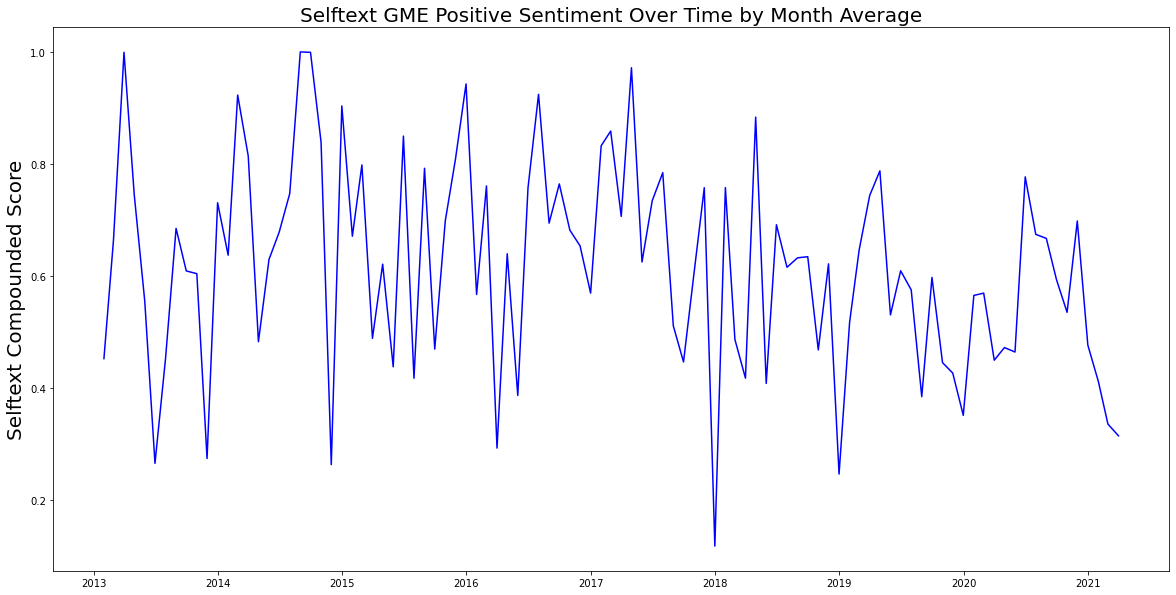

In [9]:
gmeselftext = subselftextsent[subselftextsent['selftext'].str.contains('GME|gme|GameStop')]
print("gmeselftextshape",gmeselftext.shape)
gmetitle = subselftextsent[subselftextsent['title'].str.contains('GME|gme|GameStop')]
print("gmetitleshape",gmetitle.shape)                           
gmedata = pd.concat([gmeselftext, gmetitle], axis=0)
print("gmedatashape(combined)",gmedata.shape)
gmedata['timestamp'] = pd.to_datetime(gmedata['timestamp'])

gmedatabyday = gmedata.groupby([gmedata['timestamp'].dt.date]).mean()
print("gmedatashapebyday",gmedatabyday.shape)

gmedatabyweek = gmedata.set_index('timestamp').resample('W').mean()
print("gmedatashapebyweek",gmedatabyweek.shape)

gmedatabymonth = gmedata.set_index('timestamp').resample('M').mean()
print("gmedatashapebymonth",gmedatabymonth.shape)

# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(gmedatabymonth.index, gmedatabymonth.selftextcompound, color = "blue")
# Create a descriptive title
plt.title("Selftext GME Positive Sentiment Over Time by Month Average",size=20)
#plt.legend(['Cleantext'])

# Add axis labels
plt.ylabel("Selftext Compounded Score",size=20);

amcselftextshape (409, 12)
amcselftitleshape (1124, 12)
amcdatashape(combined) (1533, 12)
amcdatashapebyday (1100, 7)
amcdatashapebyweek (428, 7)
amcdatashapebymonth (100, 7)


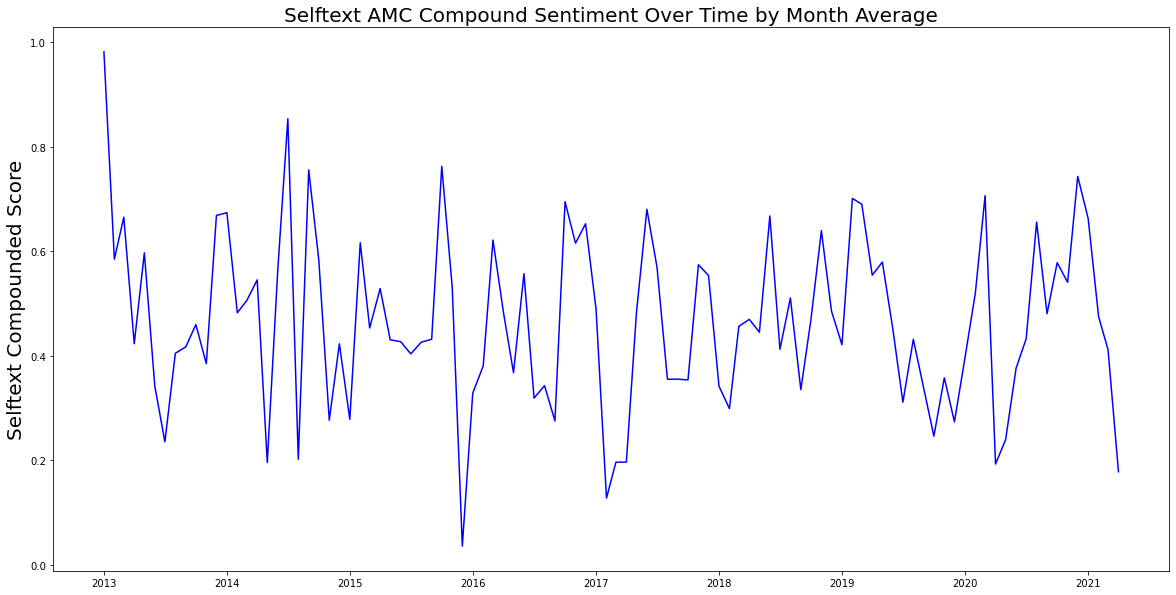

In [10]:
amcselftext = subselftextsent[subselftextsent['selftext'].str.contains('amc|amcmovies|AMC|Entertainment')]
print("amcselftextshape",amcselftext.shape)
amctitle = subselftextsent[subselftextsent['title'].str.contains('amc|amc|Index')]
print("amcselftitleshape",amctitle.shape)                           
amcdata = pd.concat([amcselftext, amctitle], axis=0)
print("amcdatashape(combined)",amcdata.shape)
amcdata['timestamp'] = pd.to_datetime(amcdata['timestamp'])

amcdatabyday = amcdata.groupby([amcdata['timestamp'].dt.date]).mean()
print("amcdatashapebyday",amcdatabyday.shape)

amcdatabyweek = amcdata.set_index('timestamp').resample('W').mean()
print("amcdatashapebyweek",amcdatabyweek.shape)

amcdatabymonth = amcdata.set_index('timestamp').resample('M').mean()
print("amcdatashapebymonth",amcdatabymonth.shape)

# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(amcdatabymonth.index, amcdatabymonth.selftextcompound, color = "blue")
# Create a descriptive title
plt.title("Selftext AMC Compound Sentiment Over Time by Month Average",size=20)
#plt.legend(['Cleantext'])

# Add axis labels
plt.ylabel("Selftext Compounded Score",size=20);

In [11]:
key = "..."
base_url = "https://www.alphavantage.co/query"

def get_stock_data(ticker):
    url = base_url
    res = requests.get(url=url, 
                      params={"function":"TIME_SERIES_DAILY_ADJUSTED",
                              "symbol":ticker,
                              "outputsize":"full",
                              "adjusted":"True",
                              "apikey":key})
    print(res.status_code)
    data = res.json()['Time Series (Daily)']
    return pd.DataFrame(data).T

TSLA=get_stock_data('TSLA')
AMC=get_stock_data('AMC')
GME=get_stock_data('GME')

new_columns={
    '1. open':'open',
    '2. high':'high',
    '3. low':'low',
    '4. close':'close',
    '5. adjusted close':'adj_close',
    '6. volume':'volume',
    '7. dividend amount':'dividend_amount',
    '8. split coefficient':'split_coefficient'}

TSLA.rename(columns=new_columns,inplace=True)
GME.rename(columns=new_columns,inplace=True)
AMC.rename(columns=new_columns,inplace=True)

TSLA['open']=TSLA['open'].astype(float)
TSLA['high']=TSLA['high'].astype(float)
TSLA['low']=TSLA['low'].astype(float)
TSLA['close']=TSLA['close'].astype(float)
TSLA['adj_close']=TSLA['adj_close'].astype(float)
TSLA['volume']=TSLA['volume'].astype(float)
TSLA['dividend_amount']=TSLA['dividend_amount'].astype(float)
TSLA['split_coefficient']=TSLA['split_coefficient'].astype(float)

TSLA.sort_index(inplace=True)

200
200
200


# TESLA

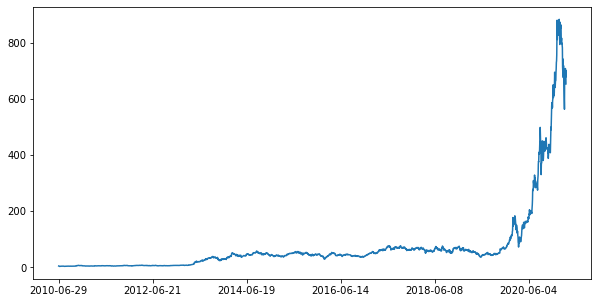

In [12]:
# Plot volume
plt.figure(figsize=(10,5))
TSLA['adj_close'].astype(float).plot();

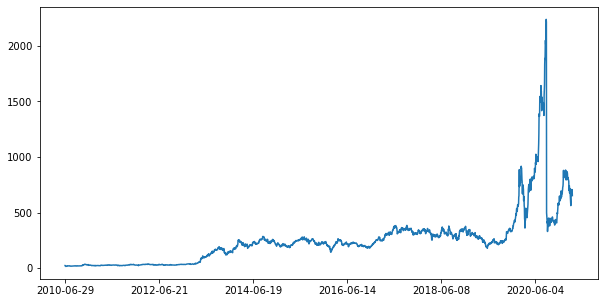

In [13]:
# Plot volume
plt.figure(figsize=(10,5))
TSLA['close'].astype(float).plot();

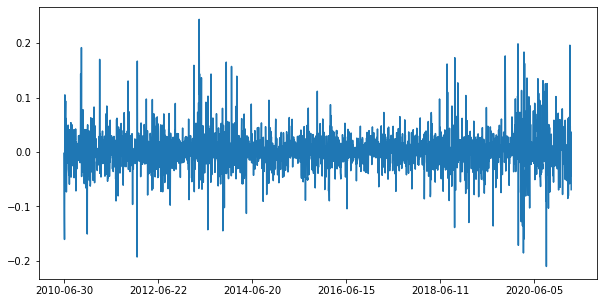

In [14]:
# Drop Adjusted Close column
TSLA.drop(columns=['dividend_amount','split_coefficient'],inplace=True)
# Convert prices to be percent changes from prior row
TSLA=TSLA.pct_change()
# Drop Nulls
TSLA.dropna(inplace=True)
# Plot adusted close
plt.figure(figsize=(10,5))
TSLA['adj_close'].plot();

In [15]:
# Create X and y
X=TSLA[['open','high','low','volume']]
y=TSLA['adj_close']
# Train/Test Split / shufle = False since we want the dates of X_test to only be AFTER all of the date in X_train
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)
# Last observation in X_train, First observation in X_test
X_train.index[-1], X_test.index[0]

('2018-07-12', '2018-07-13')

In [16]:
# Scale
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)
# Create training sequences
train_sequence = TimeseriesGenerator(Z_train,       # X data (features)
                                    y_train,        # y data (targets)
                                    length=7,       # time step
                                    batch_size=16)  # batch size is determined by the user (power of 2) , commonly 32 - 1024
train_sequence

In [17]:
batch_x, batch_y = train_sequence[0]
batch_x.shape
# batch size of 16
# time step of 7
# features of 4

(16, 7, 4)

In [18]:
batch_y.shape

(16,)

In [19]:
batch_x[0]

array([[10.84556774,  7.23346414, 10.5450624 , -0.29039633],
       [-0.99351488, -5.03175772, -4.26156362, -0.89671236],
       [-2.49988298, -3.71634833, -2.54711458, -0.69281876],
       [-4.03880274, -4.57073045, -5.03302081,  0.29170643],
       [-5.55118941, -5.7243829 , -1.79568068, -0.16275969],
       [-0.54258155,  1.74281371,  1.21067885, -0.01575683],
       [ 2.66351733,  0.67232386,  1.97148553, -0.83149088]])

In [20]:
test_sequence=TimeseriesGenerator(Z_test,
                                  y_test,
                                  length=7,
                                  batch_size=16)
input_shape = train_sequence[0][0][0].shape
input_shape

(7, 4)

In [21]:
%%time
model = Sequential()
# 1st GRU Layer: Accepts a sequence of 7 observations
model.add(GRU(7, input_shape = input_shape, return_sequences = True)) # Output the sequence to pass into next GRU layer
# 2nd GRU Layer: Accepts a sequence of 7 observations
model.add(GRU(7, return_sequences= False))  # In final recurrent layer output sequences = FALSE
# Hidden Layer 1
model.add(Dense(4, activation= "relu")) 
# Hidden Layer 2
#model.add(Dense(12, activation= "relu"))
# Output Layer
model.add(Dense(1, activation = "linear")) 
# Compile the Model
model.compile(optimizer = Adam(lr = 0.0005), 
              loss = "mse",
              metrics= ["MSE"])
history = model.fit(train_sequence,
                    validation_data = test_sequence,
                    epochs= 100,
                    batch_size=16,
                    verbose=1)

Epoch 1/100
126/126 [==============================] - 3s 10ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0033 - val_MSE: 0.0033
Epoch 2/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0014 - MSE: 0.0014 - val_loss: 0.0028 - val_MSE: 0.0028
Epoch 3/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0010 - MSE: 0.0010 - val_loss: 0.0025 - val_MSE: 0.0025
Epoch 4/100
126/126 [==============================] - 1s 5ms/step - loss: 9.3564e-04 - MSE: 9.3564e-04 - val_loss: 0.0024 - val_MSE: 0.0024
Epoch 5/100
126/126 [==============================] - 1s 5ms/step - loss: 9.6316e-04 - MSE: 9.6316e-04 - val_loss: 0.0023 - val_MSE: 0.0023
Epoch 6/100
126/126 [==============================] - 1s 5ms/step - loss: 9.3772e-04 - MSE: 9.3772e-04 - val_loss: 0.0023 - val_MSE: 0.0023
Epoch 7/100
126/126 [==============================] - 1s 5ms/step - loss: 0.0010 - MSE: 0.0010 - val_loss: 0.0023 - val_MSE: 0.0023
Epoch 8/100
126/126 [=======================

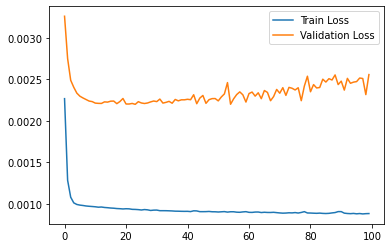

In [62]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [59]:
TSLA.reset_index(inplace=True)
TSLA = TSLA.rename(columns = {'index':'timestamp'})

TSLA['timestamp'] = pd.to_datetime(TSLA['timestamp'])
new_columns={'timestamp':'index'}

TSLA.rename(columns=new_columns,inplace=True)
TSLA = TSLA.set_index('index')

In [24]:
tsladatabyday.reset_index(inplace=True)
tsladatabyday = tsladatabyday.rename(columns = {'timestamp':'index'})
tsladatabyday['index'] = pd.to_datetime(tsladatabyday['index'])
tsladatabyday = tsladatabyday.set_index('index')
TSLAno = TSLA.reset_index()

In [25]:
# Financial Data
TSLAdaily = TSLA
TSLAweekly = TSLAno.set_index('index').resample('W').mean()
TSLAmonthly = TSLAno.set_index('index').resample('M').mean()

In [26]:
# Sentiment Data
tsladatabyday = tsladatabyday
tsladatabyweek = tsladatabyweek
tsladatabymonth = tsladatabymonth

# Merge Financial Data and Sentiment Data

In [27]:
TSLAbothdaily = pd.merge(left=TSLA,
                         right = tsladatabyday,
                         left_on=TSLA.index,
                         right_on=tsladatabyday.index,
                         how='left')
print(TSLAbothdaily.shape)
TSLAbothdaily.dropna(inplace=True)
print(TSLAbothdaily.shape)
new_columns={'key_0':'index'}
TSLAbothdaily.rename(columns=new_columns,inplace=True)
TSLAbothdaily = TSLAbothdaily.set_index('index')

(2698, 14)
(1441, 14)


In [28]:
TSLAbothweekly = pd.merge(left=TSLAweekly,
                right = tsladatabyweek,
                left_on=TSLAweekly.index,
                right_on=tsladatabyweek.index,
                how='left')
print(TSLAbothweekly.shape)
TSLAbothweekly.dropna(inplace=True)
print(TSLAbothweekly.shape)

new_columns={'key_0':'index'}
TSLAbothweekly.rename(columns=new_columns,inplace=True)
TSLAbothweekly = TSLAbothweekly.set_index('index')

(560, 14)
(421, 14)


In [29]:
TSLAbothmonthly = pd.merge(left=TSLAmonthly,
                right = tsladatabymonth,
                left_on=TSLAmonthly.index,
                right_on=tsladatabymonth.index,
                how='left')
print(TSLAbothmonthly.shape)
TSLAbothmonthly.dropna(inplace=True)
print(TSLAbothmonthly.shape)

new_columns={'key_0':'index'}
TSLAbothmonthly.rename(columns=new_columns,inplace=True)
TSLAbothmonthly = TSLAbothmonthly.set_index('index')

(130, 14)
(99, 14)


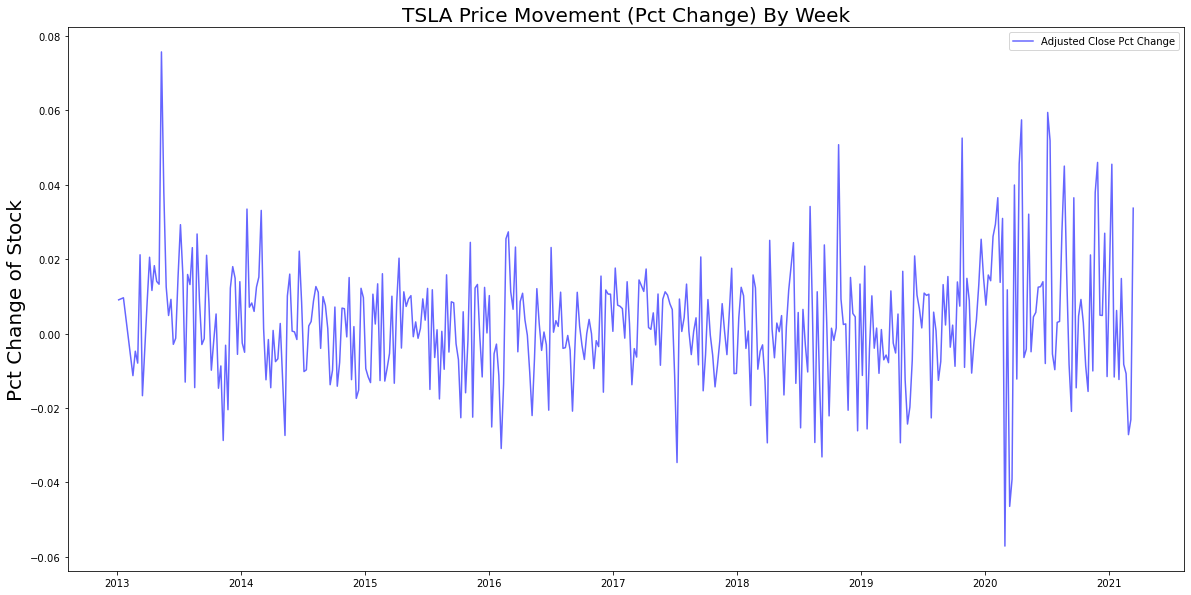

In [30]:
# Time-Series of Change in General Sentiment

# Size
plt.figure(figsize= (20,10))

# Line plot
plt.plot(TSLAbothweekly.index, TSLAbothweekly.adj_close, color = "blue",alpha=0.6, label='Adjusted Close Pct Change')

# Create a descriptive title
plt.title("TSLA Price Movement (Pct Change) By Week",size=20)

plt.legend()
# Add axis labels
plt.ylabel("Pct Change of Stock",size=20);

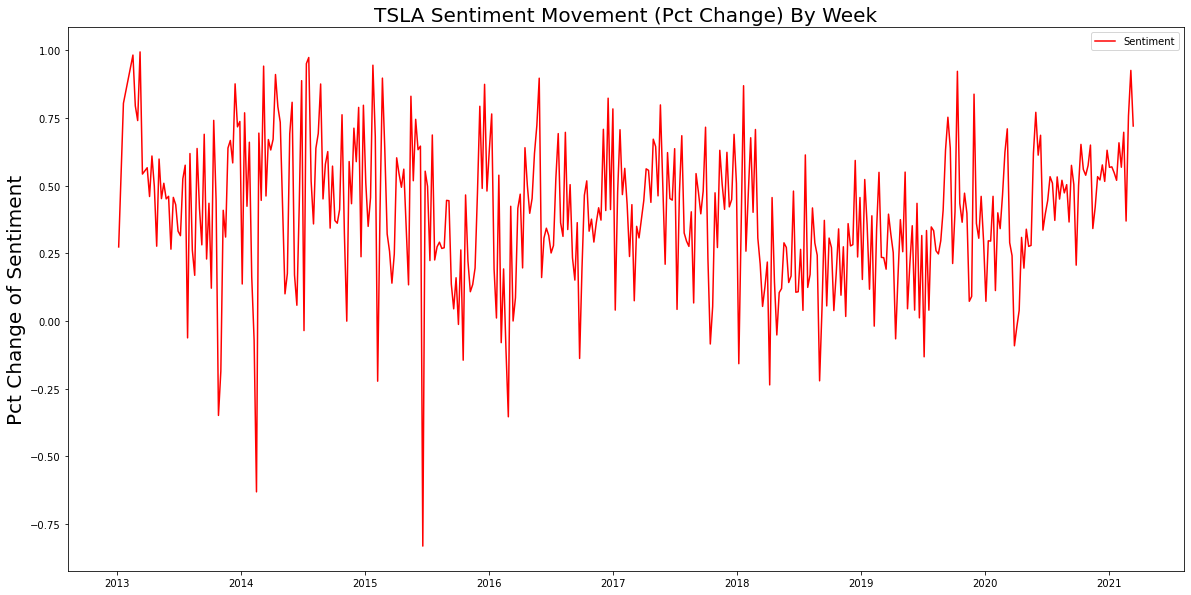

In [31]:
# Time-Series of Change in General Sentiment
# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(TSLAbothweekly.index, TSLAbothweekly.selftextcompound, color = "red", label='Sentiment')
# Create a descriptive title
plt.title("TSLA Sentiment Movement (Pct Change) By Week",size=20)
plt.legend()
# Add axis labels
plt.ylabel("Pct Change of Sentiment",size=20);

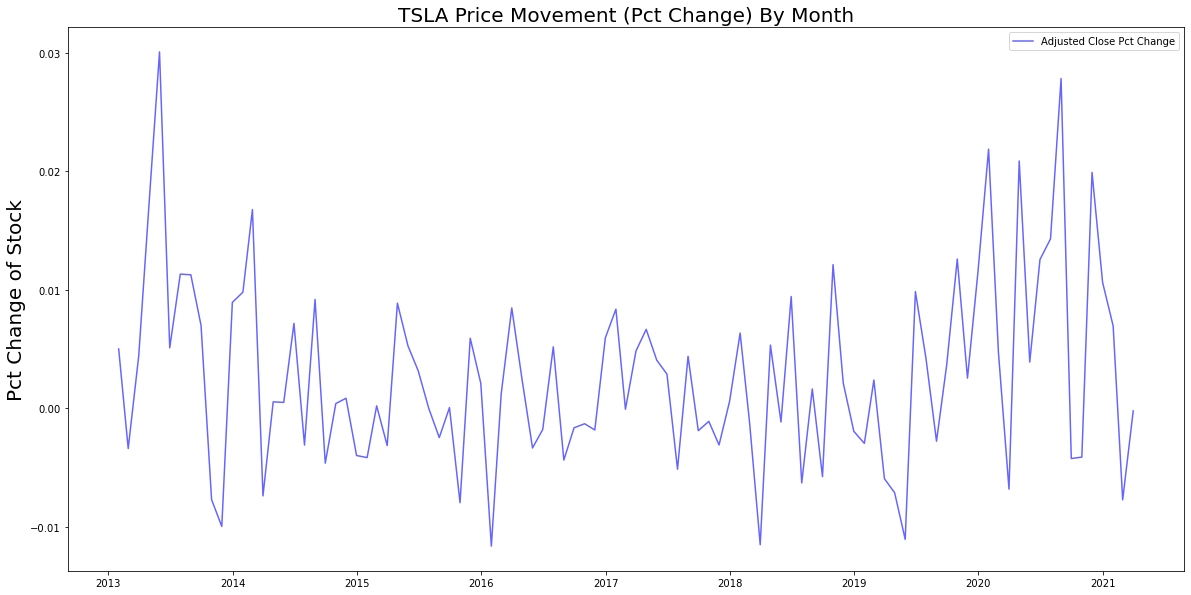

In [32]:
# Time-Series of Change in General Sentiment
# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(TSLAbothmonthly.index, TSLAbothmonthly.adj_close, color = "blue",alpha=0.6, label='Adjusted Close Pct Change')
# Create a descriptive title
plt.title("TSLA Price Movement (Pct Change) By Month",size=20)
plt.legend()
# Add axis labels
plt.ylabel("Pct Change of Stock",size=20);

<Figure size 1080x1080 with 0 Axes>

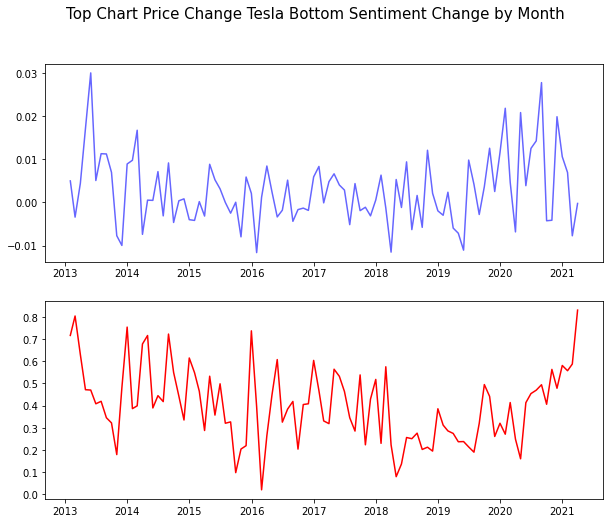

In [33]:
plt.figure(figsize = (15, 15))
#temp = pd.DataFrame({"selectedfeaturesbeforestopword": selectedfeaturesbeforestopword.index,"selectedfeaturesafterstopword": selectedfeaturesafterstopword.index})
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))
fig.suptitle("Top Chart Price Change Tesla Bottom Sentiment Change by Month",fontsize=15);
ax1.plot(TSLAbothmonthly.index, TSLAbothmonthly.adj_close, color = "blue",alpha=0.6, label='Adjusted Close Pct Change')
ax2.plot(TSLAbothmonthly.index, TSLAbothmonthly.selftextcompound, color = "red", label='Sentiment');


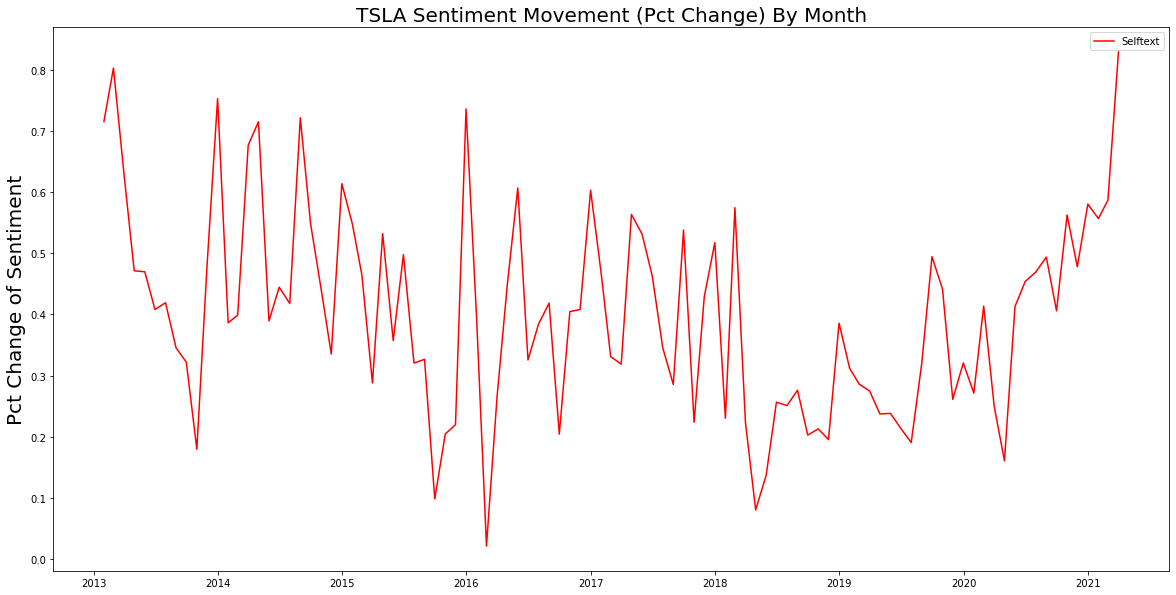

In [34]:
# Time-Series of Change in General Sentiment
# Size
plt.figure(figsize= (20,10))
# Line plot
plt.plot(TSLAbothmonthly.index, TSLAbothmonthly.selftextcompound, color = "red", label='Sentiment')
# Create a descriptive title
plt.title("TSLA Sentiment Movement (Pct Change) By Month",size=20)
plt.legend(['Selftext','Cleantext'])
# Add axis labels
plt.ylabel("Pct Change of Sentiment",size=20);

In [35]:
TSLAbothdaily.dtypes

open                 float64
high                 float64
low                  float64
close                float64
adj_close            float64
volume               float64
num_comments         float64
redditscore          float64
selftextwordcount    float64
selftextnegative     float64
selftextneutral      float64
selftextpositive     float64
selftextcompound     float64
dtype: object

In [36]:
TSLAbothdaily.head(0)

,open,high,low,close,adj_close,volume,num_comments,redditscore,selftextwordcount,selftextnegative,selftextneutral,selftextpositive,selftextcompound
index,,,,,,,,,,,,,


In [37]:
'open','high','low','close','adj_close','volume','num_comments','redditscore','selftextwordcount','selftextnegative','selftextneutral','selftextpositive','selftextcompound'

X=TSLAbothdaily[['open','high','low','volume','num_comments','redditscore','selftextwordcount','selftextnegative','selftextneutral','selftextpositive','selftextcompound']]
y=TSLAbothdaily['adj_close']

In [38]:
# Train/Test Split / shufle = False since we want the dates of X_test to only be AFTER all of the date in X_train
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)
# Last observation in X_train, First observation in X_test
X_train.index[-1], X_test.index[0]

(Timestamp('2019-07-10 00:00:00'), Timestamp('2019-07-11 00:00:00'))

In [39]:
# Scale
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [40]:
# Create training sequences
train_sequence = TimeseriesGenerator(Z_train,       # X data (features)
                                    y_train,        # y data (targets)
                                    length=7,       # time step
                                    batch_size=16)  # batch size is determined by the user (power of 2) , commonly 32 - 1024
train_sequence

In [41]:
test_sequence=TimeseriesGenerator(Z_test,
                                  y_test,
                                  length=7,
                                  batch_size=16)
test_sequence

In [42]:
batch_x, batch_y = train_sequence[0]
print(batch_x.shape)
print(batch_y.shape)
# batch size of 8
# time step of 7
# features of 4

(16, 7, 11)
(16,)


In [43]:
batch_x[0]

array([[ 0.08988783, -0.06745501, -0.01021963, -0.73322835,  0.69682204,
         0.29104334, -0.17732622,  0.50718868, -0.00906266, -0.33058243,
        -0.20759739],
       [-0.83919214, -0.68025016,  0.65045974, -0.77377649, -0.14809554,
        -0.11368668,  0.48136551, -0.71360757, -0.49946897,  1.03802847,
         1.026584  ],
       [ 0.20176183,  0.50483335,  0.12150607, -0.14853851, -0.28604127,
        -0.12925322, -0.38220358, -1.00977708,  0.23831044,  0.41196179,
         0.72596353],
       [ 0.29139281, -0.29355226, -0.21972081, -0.63432196,  0.80028134,
         0.02543926,  0.22912403, -0.01291387, -0.62098558,  0.70315559,
         1.28018004],
       [-0.87843042,  0.57251313,  0.24635445,  0.26279123, -0.22569001,
        -0.12341577, -0.46151094, -1.00977708,  0.79815482, -0.2141049 ,
        -0.11417831],
       [-2.04562228, -1.86874858, -3.14578314,  2.42155862,  0.03870596,
        -0.08936396,  0.49678638,  0.25436105, -0.9464765 ,  0.87787188,
         1.156

In [44]:
batch_y

array([ 0.01945977, -0.00769231,  0.03007307,  0.01432741,  0.00051151,
       -0.00357873, -0.05464341,  0.02484981, -0.00707547,  0.15940881,
        0.00933303, -0.07307172, -0.03179536,  0.04132824,  0.03344334,
        0.01830956])

In [45]:
# save the dimensions of the input
# size of the input sequence to the GRU layer. 

# The layer accepts a sequence of:
# 7 observations each of which have 4 features
input_shape = train_sequence[0][0][0].shape
input_shape

(7, 11)

In [52]:
%%time
model1 = Sequential()
# 1st GRU Layer: Accepts a sequence of 7 observations
model1.add(GRU(7, input_shape = input_shape, return_sequences = True)) # Output the sequence to pass into next GRU layer
# 2nd GRU Layer: Accepts a sequence of 7 observations
model1.add(GRU(7, return_sequences= False))  # In final recurrent layer output sequences = FALSE
# Hidden Layer 1
model1.add(Dense(4, activation= "relu")) 
# Hidden Layer 2
#model.add(Dense(12, activation= "relu"))
# Output Layer
model1.add(Dense(1, activation = "linear")) 
# Compile the Model
model1.compile(optimizer = Adam(lr = 0.0005), 
              loss = "mse",
              metrics= ["MSE"])
history1 = model1.fit(train_sequence,
                    validation_data = test_sequence,
                    epochs= 100,
                    batch_size=16,
                    verbose=0)

CPU times: user 1min 33s, sys: 21.1 s, total: 1min 54s
Wall time: 40.2 s


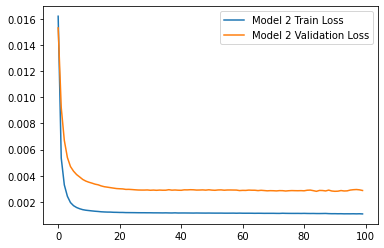

In [55]:
plt.plot(history1.history['loss'], label='Model 2 Train Loss')
plt.plot(history1.history['val_loss'], label='Model 2 Validation Loss')
plt.legend();

In [48]:
# try new hidden layers
# try EarlyStopping
# try Dropoff

# ARIMA MODEL

# SARIMAX MODEL

# LSTM Model

# RESULTS

The results from this process are still unclear and warrant further testing. Depending on the random state, sometimes results are better from model 2. I have proven that I can mine data from subreddits, clean and transform it, perform sentiment analysis on this data, mine financial data from AlphaVantage, compile the sentiment scores by date, and use those sentiment scores as a predictive feature in time series forecasting. I plan to make numerous iterations over this project to aggressively improve these results.